In [1]:
!pip install numpy
!pip install matplotlib
!pip install scipy


 Labels =  [0, 1, 2, 3]
linkage matrix :  [[2.00000000e+00 3.00000000e+00 1.90612172e+02 2.00000000e+00]
 [1.00000000e+00 4.00000000e+00 6.56544743e+02 3.00000000e+00]
 [0.00000000e+00 5.00000000e+00 1.76878405e+03 4.00000000e+00]]


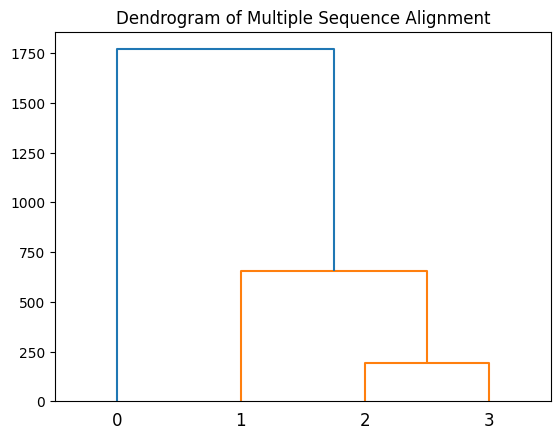

Multiple Sequence Alignment:
>1
G-A-R-F-I-E-L-D_THE_L-AST-_F-A-T--_-C-A-T--G--A--R--F--I--E--L-----D-_--T---HE------_-F--A--S-T--_--C--A--T---------------------------------------------G--A--R--F--I--E--L-----D-_--T---HE_VERY_--F--A--S-T--------_--C--A--T------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------T-H-E_FAT_----CA-T
>2
G-A-R-F-I-E-L-----D_T-HE--_F-A-S-T-_-C-A-T--G-A-R-F-I-E-LD_T-H-E-_V-E-RY_-F--A--S-T--_--C--A--T-------------------------------------------------------------T-H------E----_F--A----T--_--C--A--T
>3
GARFIELD_T-H-E_VE-RY_F-A-ST-_-C-A-T-----------T-H----E---_F-A--T-_-C-A-T
>4
THE_FAT_CAT


In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
import random

# Define the sequences

a = 'GARFIELD_THE_LAST_FAT_CAT'
b = 'GARFIELD_THE_FAST_CAT'
c = 'GARFIELD_THE_VERY_FAST_CAT'
d = 'THE_FAT_CAT'

sequences = [a,b,c,d]

# Placeholder function for pairwise distance calculation
def calculate_pairwise_distance(seq1, seq2):
    """
    Placeholder function for pairwise distance calculation using ClustalW.

    This is a simple scoring scheme:
    - Match: +1
    - Mismatch: -1
    - Gap Penalty: -2

    Args:
        seq1: The first sequence.
        seq2: The second sequence.

    Returns:
        The pairwise distance between the two sequences.
    """
    match_score = 1
    mismatch_score = -1
    gap_penalty = -2

    distance = 0
    max_length = max(len(seq1), len(seq2))

    for i in range(max_length):
        char1 = seq1[i] if i < len(seq1) else '-'
        char2 = seq2[i] if i < len(seq2) else '-'

        if char1 == '-' or char2 == '-':
            distance += gap_penalty
        elif char1 == char2:
            distance += match_score
        else:
            distance += mismatch_score

    return distance


# Function to calculate pairwise distances using ClustalW
def pairwise_distance_matrix(sequences):
    # Calculate pairwise distances for all sequences
    num_sequences = len(sequences)
    distances = np.zeros((num_sequences, num_sequences))

    for i in range(num_sequences):
        for j in range(i + 1, num_sequences):
            distances[i, j] = calculate_pairwise_distance(sequences[i], sequences[j])
            distances[j, i] = distances[i, j]

    return distances

# Calculate pairwise distances
distances = pairwise_distance_matrix(sequences)


# Calculate the alignment score between two sequences
def calculate_alignment_score(seq1, seq2):
    """
    Calculate the alignment score between two sequences.

    Args:
        seq1: The first aligned sequence.
        seq2: The second aligned sequence.

    Returns:
        The alignment score.
    """
    if len(seq1) != len(seq2):
        return 0  # Return 0 when the lengths are not equal

    score = 0
    for i in range(len(seq1)):
        if seq1[i] != "-" and seq2[i] != "-":
            if seq1[i] == seq2[i]:
                score += 2
            else:
                score -= 1
    return score

# Scoring and optimization
def scoring_and_optimization(aligned_sequences, max_iterations=10):
    best_aligned_sequences = aligned_sequences.copy()
    best_score = calculate_total_alignment_score(best_aligned_sequences)

    for _ in range(max_iterations):
        # Randomly choose two sequences to align
        seq_indices = random.sample(range(len(aligned_sequences)), 2)
        seq1_index, seq2_index = seq_indices[0], seq_indices[1]

        # Extract the selected sequences
        seq1 = best_aligned_sequences[seq1_index]
        seq2 = best_aligned_sequences[seq2_index]

        # Optimize the alignment for the current pair
        aligned_seq1, aligned_seq2, current_score = optimize_alignment(seq1, seq2, best_score)

        # Update the best alignment if the score improves
        aligned_sequences_copy = best_aligned_sequences.copy()
        aligned_sequences_copy[seq1_index] = aligned_seq1
        aligned_sequences_copy[seq2_index] = aligned_seq2

        if current_score > best_score:
            best_aligned_sequences = aligned_sequences_copy
            best_score = current_score

    return best_aligned_sequences

# Function to calculate the total alignment score for a set of aligned sequences
def calculate_total_alignment_score(aligned_sequences):
    """
    Calculate the total alignment score for a set of aligned sequences.
    """
    total_score = 0
    for i in range(len(aligned_sequences)):
        for j in range(i + 1, len(aligned_sequences)):
            total_score += calculate_alignment_score(aligned_sequences[i], aligned_sequences[j])
    return total_score

#Function to calculate distance matrix based on aligned sequences
def update_distance_matrix(distances, aligned_sequences):
    """
    Update the pairwise distance matrix based on aligned sequences.
    """
    updated_distances = np.zeros((len(aligned_sequences), len(aligned_sequences)))

    string_aligned_sequences = {key: "".join(value) for key, value in aligned_sequences.items()}

    for i, aligned_seq1 in aligned_sequences.items():
        for j, aligned_seq2 in aligned_sequences.items():
            if len(aligned_seq1) != len(aligned_seq2):
                continue
            distance = 0

            max_length = max(len(aligned_seq1), len(aligned_seq2))

            for k in range(max_length):
                if k < len(aligned_seq1) and k < len(aligned_seq2):
                    char1 = aligned_seq1[k]
                    char2 = aligned_seq2[k]

                    if char1 != "-" and char2 != "-":
                        if char1 != char2:
                            distance += 1

            updated_distances[i, j] = distance
            updated_distances[j, i] = distance

    return updated_distances

# Neighbor-Joining tree construction
def nj_tree_construction(distances):
    """
    Construct a neighbor-joining tree from a distance matrix.
    """
    n = len(distances)
    tree = {}

    for i, _ in enumerate(distances):
        for j in range(i + 1, n):
            tree[(i, j)] = (i, j)

    closest_leaves = None
    found_closest_leaves = False
    for i in tree.keys():
        for j in tree.keys():
            if isinstance(i, int) and isinstance(j, int):
                if i < j:
                    if distances[i, j] < min_distance:
                        min_distance = distances[i, j]
                        closest_leaves = (i, j)
                        found_closest_leaves = True

    if found_closest_leaves:
        for k in range(n):
            if k == closest_leaves[0] or k == closest_leaves[1]:
                continue

            distances[closest_leaves[0], k] = (distances[i, k] + distances[j, k] - distances[i, j]) / 2
            distances[k, closest_leaves[0]] = distances[closest_leaves[0], k]

        new_node = n
        tree[(closest_leaves[0], closest_leaves[1])] = (n, closest_leaves[0])
        tree[n] = (closest_leaves[1], n)
        n += 1

    return tree

# Perform pairwise alignment of two sequences using ClustalW
def align_sequences(seq1, seq2):
    """
    Perform pairwise alignment of two sequences using ClustalW.
    """
    score_matrix = np.zeros((len(seq1) + 1, len(seq2) + 1))

    for i in range(1, len(seq1) + 1):
        score_matrix[i, 0] = -i
    for j in range(1, len(seq2) + 1):
        score_matrix[0, j] = -j

    for i in range(1, len(seq1) + 1):
        for j in range(1, len(seq2) + 1):
            if seq1[i - 1] == seq2[j - 1]:
                match_score = 2
            else:
                match_score = -1
                score_matrix[i, j] = max(score_matrix[i - 1, j] - 1,score_matrix[i, j - 1] - 1,score_matrix[i - 1, j - 1] + match_score,)

    aligned_seq1, aligned_seq2 = "", ""
    i, j = len(seq1), len(seq2)
    while i > 0 or j > 0:
        aligned_seq1_i, aligned_seq2_i = "", ""

        if i > 0 and j > 0:
            if score_matrix[i, j] == score_matrix[i - 1, j - 1] + match_score:
                aligned_seq1_i = seq1[i - 1] + aligned_seq1_i
                aligned_seq2_i = seq2[j - 1] + aligned_seq2_i
                i -= 1
                j -= 1
            elif score_matrix[i, j] == score_matrix[i - 1, j] - 1:
                aligned_seq1_i = seq1[i - 1] + aligned_seq1_i
                aligned_seq2_i = "-" + aligned_seq2_i
                i -= 1
            else:
                aligned_seq1_i = "-" + aligned_seq1_i
                aligned_seq2_i = seq2[j - 1] + aligned_seq2_i
                j -= 1
        else:
            if i > 0:
                aligned_seq1_i = seq1[i - 1] + aligned_seq1_i
                aligned_seq2_i = "-" + aligned_seq2_i
                i -= 1
            else:
                aligned_seq1_i = "-" + aligned_seq1_i
                aligned_seq2_i = seq2[j - 1] + aligned_seq2_i
                j -= 1

        aligned_seq1 = aligned_seq1_i + aligned_seq1
        aligned_seq2 = aligned_seq2_i + aligned_seq2

    return aligned_seq1 + aligned_seq2

# Perform progressive alignment of sequences based on a guide tree
def progressive_alignment(sequences, tree):
    """
    Perform progressive alignment of sequences based on a guide tree.
    """
    aligned_sequences = {i: sequences[i] for i in range(len(sequences))}

    for leaf in tree.keys():
        if isinstance(leaf, int):
            continue

        seq1_id, seq2_id = leaf
        if seq1_id not in aligned_sequences:
            aligned_sequences[seq1_id] = "-" * len(aligned_sequences[0])

        if seq2_id not in aligned_sequences:
            aligned_sequences[seq2_id] = "-" * len(aligned_sequences[0])

        aligned_sequences[seq1_id] = align_sequences(aligned_sequences[seq1_id], aligned_sequences[seq2_id])

    return aligned_sequences

# Visualize the multiple sequence alignment using a dendrogram
def visualization(optimized_aligned_sequences):
    """
    Visualize the multiple sequence alignment using a dendrogram.
    """
    sequence_ids = list(optimized_aligned_sequences.keys())
    sequences = list(optimized_aligned_sequences.values())

    distances = np.zeros((len(sequences), len(sequences)))
    for i in range(len(sequences)):
        for j in range(i + 1, len(sequences)):
            distances[i, j] = calculate_pairwise_distance(sequences[i], sequences[j])
            distances[j, i] = distances[i, j]

    linkage_matrix = linkage(distances, method="ward")
    print(" Labels = ", sequence_ids)
    print("linkage matrix : ", linkage_matrix)
    fig, ax = plt.subplots()
    dendrogram(linkage_matrix, labels=sequence_ids, ax=ax)
    plt.title("Dendrogram of Multiple Sequence Alignment")
    plt.show()


# Generate the final multiple sequence alignment from the guide tree
def msa_from_guide_tree(sequences, tree):
    """
    Generate the final multiple sequence alignment from the guide tree.
    """
    aligned_sequences = progressive_alignment(sequences, tree.copy())
    aligned_sequences = scoring_and_optimization(aligned_sequences)
    return aligned_sequences

# Extend the alignment to improve the score
def extend_alignment(seq1, seq2, mismatch_index, extension_length, to_right=True):
    max_len = max(len(seq1), len(seq2))
    extended_seq1 = list(seq1)
    extended_seq2 = list(seq2)

    for i in range(mismatch_index, min(mismatch_index + extension_length, max_len)):
        # Check if there is a mismatch
        if i < len(seq1) and i < len(seq2) and seq1[i] != seq2[i]:
            # Introduce a gap in both sequences
            extended_seq1[i] = '-'
            extended_seq2[i] = '-'

    if to_right:
        # Extend to the right
        for i in range(min(mismatch_index + extension_length, max_len), max_len):
            # Check if there is a mismatch
            if i < len(seq1) and i < len(seq2) and seq1[i] != seq2[i]:
                # Introduce a gap in both sequences
                extended_seq1.append('-')
                extended_seq2.append('-')

    return ''.join(extended_seq1), ''.join(extended_seq2)

# Optimize the alignment by trying different extensions
def optimize_alignment(seq1, seq2, current_score):
    aligned_seq1 = list(seq1)
    aligned_seq2 = list(seq2)
    max_len = max(len(seq1), len(seq2))
    best_score = current_score

    for i in range(max_len):
        # Check if there is a mismatch
        if i < len(seq1) and i < len(seq2) and seq1[i] != seq2[i]:
            # Try different extensions and choose the one with the best score
            for extension_length in range(1, max_len):
                left_extended_seq1, left_extended_seq2 = extend_alignment(aligned_seq1, aligned_seq2, i, extension_length, False)
                right_extended_seq1, right_extended_seq2 = extend_alignment(aligned_seq1, aligned_seq2, i, extension_length, True)

                left_score = calculate_alignment_score(left_extended_seq1, left_extended_seq2)
                right_score = calculate_alignment_score(right_extended_seq1, right_extended_seq2)

                if left_score > best_score:
                    aligned_seq1, aligned_seq2 = left_extended_seq1, left_extended_seq2
                    best_score = left_score
                if right_score > best_score:
                    aligned_seq1, aligned_seq2 = right_extended_seq1, right_extended_seq2
                    best_score = right_score

    return ''.join(aligned_seq1), ''.join(aligned_seq2), best_score


#### Start calling the functions to generate the Multiple-Sequence-Alignment (MSA) for the given input sequence
# Step-1: Calculate pairwise distances
distances = pairwise_distance_matrix(sequences)

# Step-2: Neighbor-Joining tree construction
tree = nj_tree_construction(distances)

# Step-3: Iterative refinement
aligned_sequences = progressive_alignment(sequences, tree.copy())
for _ in range(5):
    #Step 3.1
    updated_distances = update_distance_matrix(distances, aligned_sequences)
    #Step 3.2
    updated_tree = nj_tree_construction(updated_distances)
    #Step 3.3
    aligned_sequences = progressive_alignment(sequences, updated_tree.copy())

# Step-4: Scoring and optimization
optimized_aligned_sequences = scoring_and_optimization(aligned_sequences.copy())

# Step-5: Visualization
visualization(optimized_aligned_sequences)

# Step-6: Final multiple sequence alignment from the guide tree
final_aligned_sequences = msa_from_guide_tree(sequences, tree)

# Step-7: Print the final multiple sequence alignment
print("Multiple Sequence Alignment:")
for i, (sequence_id, aligned_sequence) in enumerate(final_aligned_sequences.items()):
    print(f">{sequence_id + 1}")
    print(aligned_sequence)
